<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;"><img src="https://pbs.twimg.com/profile_images/1187259618/unidata_logo_rgb_sm_400x400.png" alt="Unidata Logo" style="height: 98px;"></div>

<h1>Working with Surface Observations in Siphon and MetPy</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="http://weather-geek.net/images/metar_what.png" alt="METAR" style="height: 200px;"></div>


## What is METAR?
 * Surface observational data
 * Access via a URL constructed from a web form
 * Returns csv, xml, or NetCDF formatted data
 * [http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.html?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr](http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.html?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr)

In [1]:
%matplotlib inline

import numpy as np
from datetime import datetime, timedelta

## Construct our request to the TDS using the expected base URL and our query string
 * Open your browser and go to http://thredds.ucar.edu/thredds/catalog.html
 * Find METR data under "Observation Data/"
 * Go to the METR dataset called "Feature Collection" - this is the THREDDS catalog in html form
 * In the url, change ".html" to ".xml" - this is actual THREDDS Catalog. The THREDDS catalog tells you what data is available and how it can be accessed.
 * We will use the Unidata python library "siphon" to read the catalog and access the actual METAR data.

In [2]:
from siphon.catalog import TDSCatalog
# copied from the browser url box
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
# parse the xml
metar_cat = TDSCatalog(metar_cat_url)
# what datasets are here? only one "dataset" in this catalog
dataset = list(metar_cat.datasets.values())[0]
print(dataset.name)

Feature Collection


## What kind of access methods are available?

In [3]:
print(list(dataset.access_urls))

['NetcdfSubset']


## NetcdfSubset it is!

In [4]:
ncss_url = dataset.access_urls["NetcdfSubset"]

## Ok...but what is NetcdfSubset
 * A web service for subsetting CDM scientific datasets
 * The subsetting is specified using earth coordinates
  * lat/lon or projection coordinates, bounding boxes, date ranges
  * <b>Not</b> index based!
 * Check out the details in your browser: http://www.unidata.ucar.edu/software/thredds/v4.6/tds/reference/NetcdfSubsetServiceReference.html
 * Rather than construct the request "by hand", let's use siphon!

In [5]:
from siphon.ncss import NCSS
ncss = NCSS(ncss_url)

## Whaddya want?

What variables do we have available?

In [6]:
ncss.variables

{'air_pressure_at_sea_level',
 'air_temperature',
 'cloud_area_fraction',
 'dew_point_temperature',
 'hectoPascal_ALTIM',
 'high_cloud_area_fraction',
 'high_cloud_base_altitude',
 'inches_ALTIM',
 'low_cloud_area_fraction',
 'low_cloud_base_altitude',
 'middle_cloud_area_fraction',
 'middle_cloud_base_altitude',
 'numChildren',
 'precipitation_amount_24',
 'precipitation_amount_hourly',
 'report',
 'report_id',
 'report_length',
 'snowfall_amount',
 'snowfall_amount_last_hour',
 'visibility_in_air',
 'visibility_in_air_direction',
 'visibility_in_air_surface',
 'visibility_in_air_vertical',
 'weather',
 'wind_from_direction',
 'wind_from_direction_max',
 'wind_from_direction_min',
 'wind_gust',
 'wind_peak_from_direction',
 'wind_peak_speed',
 'wind_peak_time',
 'wind_speed',
 'xfields'}

* Let's say we want the past days worth of data...
* ...for "here" (i.e. the lat/lon)
* ...for the variables mean sea level pressure, air temperature, wind direction, and wind_speed
* ...and for fun, let's get the data back as a netCDF file

In [7]:
# get current date and time
now = datetime.utcnow() - timedelta(days=5)
now = datetime(now.year, now.month, now.day, now.hour)

# define the time range we are interested in
start_time = now - timedelta(days=1)
end_time = now

# build the query
query = ncss.query()
query.lonlat_point(-104.66, 39.85)
query.time_range(start_time, end_time)
query.variables('inches_ALTIM', 'air_temperature', 'dew_point_temperature',
                'wind_from_direction', 'wind_speed')
query.accept('netcdf')

# what does the request url look like?
print(query)

var=air_temperature&var=dew_point_temperature&var=wind_speed&var=inches_ALTIM&var=wind_from_direction&time_end=2016-04-03T03%3A00%3A00&time_start=2016-04-02T03%3A00%3A00&latitude=39.85&longitude=-104.66&accept=netcdf


## Let's get the data!

In [8]:
data = ncss.get_data(query)

## What did we get back?
 * That's right, a netcdf4-python dataset!
 * Is that what you expected?

In [9]:
print(list(data.variables))

['latitude', 'longitude', 'stationAltitude', 'station_id', 'station_description', 'wmo_id', 'time', 'stationIndex', 'wind_from_direction', 'wind_speed', 'air_temperature', 'dew_point_temperature', 'inches_ALTIM']


## What station did we get?

In [10]:
station_id = data['station_id'][:].tostring()
print(station_id)

b'DEN'


## Notice anything funny?
 * the "b" means it's a byte encoded string
 * let's use something sane like, uhh, utf-8

In [11]:
station_id = station_id.decode("utf-8")
print(station_id)

DEN


## Let's get the time (in seconds since 1970-01-01) into a datetime object

In [12]:
time = [datetime.fromtimestamp(t) for t in data['time']]

## Now for the obligatory time series plot...

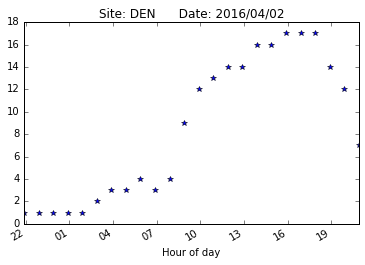

In [13]:
from matplotlib import pyplot as plt
from matplotlib.dates import HourLocator,DateFormatter, AutoDateLocator

fig, ax1 = plt.subplots(1, 1)
ax1.plot(time, data['air_temperature'], '*')

locator = AutoDateLocator()
hoursFmt = DateFormatter('%H')

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(hoursFmt)
ax1.autoscale_view()
ax1.set_title('Site: {}      Date: {}'.format(station_id, time[0].strftime('%Y/%m/%d')))
ax1.set_xlabel('Hour of day')
#ax1.set_ylabel(t_air_label)
fig.autofmt_xdate()
plt.show()

So we have dewpoint, can we do a time series of mixing ratio?

We can use MetPy's unit support and calculations for this.

In [14]:
import metpy.calc
from metpy.units import units

In [15]:
print(data.variables['dew_point_temperature'].units)
print(data.variables['inches_ALTIM'].units)

Celsius
inches


In [16]:
dewp = data.variables['dew_point_temperature'][:] * units('degC')
slp = data.variables['inches_ALTIM'][:] * units('inHg')

Look at the docs for `metpy.calc.mixing_ratio` and `metpy.calc.saturation_vapor_pressure`.

So to get mixing ratio, we need the ambient partial pressure--we can get that by passing dewpoint temperature to `metpy.calc.saturation_vapor_pressure()`.

In [17]:
e = metpy.calc.saturation_vapor_pressure(dewp)
e

<Quantity([ 3.62281704  3.91123843  3.62281704  3.91123843  3.91123843  3.91123843
  4.21990967  3.62281704  3.91123843  3.91123843  3.62281704  3.62281704
  3.91123843  3.91123843  3.91123843  3.91123843  3.62281704  3.62281704
  3.62281704  3.62281704  4.55005455  3.91123843  3.91123843  3.62281704], 'millibar')>

In [18]:
slp

<Quantity([ 30.09000015  30.11000061  30.14999962  30.18000031  30.20999908
  30.22999954  30.25        30.26000023  30.25        30.23999977
  30.22999954  30.21999931  30.20999908  30.20999908  30.20999908
  30.20999908  30.20999908  30.21999931  30.20999908  30.19000053
  30.07999992  30.06999969  30.06999969  30.06999969], 'in_Hg')>

So we can pass these to mixing ratio and get...

In [19]:
m = metpy.calc.mixing_ratio(e, slp)
m

<Quantity([ 0.0751532   0.08110528  0.07500312  0.08091643  0.08083578  0.08078209
  0.08712585  0.07472949  0.08072848  0.08075528  0.07480393  0.07482877
  0.08083578  0.08083578  0.08083578  0.08083578  0.07485362  0.07482877
  0.07485362  0.07490338  0.09450603  0.08121359  0.08121359  0.07520337], 'millibar / in_Hg')>

Hmmm....need to get this to reduce

In [20]:
# Could also to m.ito('dimensionless')
m.ito_base_units()
m

<Quantity([ 0.00221927  0.00239504  0.00221484  0.00238946  0.00238708  0.00238549
  0.00257282  0.00220676  0.00238391  0.0023847   0.00220896  0.00220969
  0.00238708  0.00238708  0.00238708  0.00238708  0.00221043  0.00220969
  0.00221043  0.0022119   0.00279076  0.00239824  0.00239824  0.00222075], 'dimensionless')>

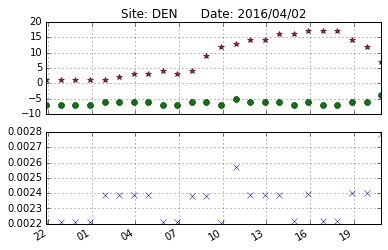

In [21]:
from matplotlib import pyplot as plt
from matplotlib.dates import HourLocator,DateFormatter, AutoDateLocator

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(time, data['air_temperature'], 'r*')
ax1.plot(time, data['dew_point_temperature'], 'go')
ax1.grid(True)

ax2.plot(time, m, 'x')
ax2.grid(True)

locator = AutoDateLocator()
hoursFmt = DateFormatter('%H')

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(hoursFmt)
ax1.autoscale_view()
ax1.set_title('Site: {}      Date: {}'.format(station_id, time[0].strftime('%Y/%m/%d')))
ax1.set_xlabel('Hour of day')
fig.autofmt_xdate()
plt.show()

### Exercise

Time to make your own meteogram:
1. Calculate your own quantity/quantities of interest. (e.g. relative humidity, wind chill, heat index)
2. Plot the values as a function of time.
3. Bonus points: Use more than one subplot
4. More bonus points: Explore time formatting

## Now, let's request all stations within a bounding box for a given time and create a surface "station plot"
 * Make new NCSS query
 * Request data closest to "now"
 * This time, let's ask for the data in csv format

In [22]:
bb = {'north' : 45,
      'south' : 35,
      'east' : -100,
      'west' : -110}

query = ncss.query()
query.lonlat_box(north=bb['north'], south=bb['south'], east=bb['east'], west=bb['west'])
query.time(start_time)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction')
query.accept('csv')

var=wind_speed&var=inches_ALTIM&var=air_temperature&var=cloud_area_fraction&var=dew_point_temperature&var=wind_from_direction&time=2016-04-02T03%3A00%3A00&north=45&south=35&west=-110&east=-100&accept=csv

## Let's get the data!

In [23]:
from metpy.calc import get_wind_components

data = ncss.get_data(query)

# Access is just like netcdf4-python
lats = data['latitude'][:]
lons = data['longitude'][:]
tair = data['air_temperature'][:]
dewp = data['dew_point_temperature'][:]
slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

# Convert wind to components
u, v = get_wind_components(data['wind_speed'], np.deg2rad(data['wind_from_direction']))

# Need to handle missing (NaN) and convert to proper code
cloud_cover = 8 * data['cloud_area_fraction']
cloud_cover[np.isnan(cloud_cover)] = 9
cloud_cover = cloud_cover.astype(np.int)

# For some reason these come back as bytes instead of strings
stid = [s.decode() for s in data['station']]

## Create the map using cartopy and MetPy!

Pull out the code to create the basic plot and add mapping features so we aren't repeating this everywhere.

In [24]:
import cartopy

def default_map(bb):
    fig = plt.figure(figsize=(24, 12))
    proj = cartopy.crs.Stereographic(central_longitude=-95, central_latitude=35)
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Add map features
    ax.add_feature(cartopy.feature.NaturalEarthFeature(category='cultural', 
                                                       name='admin_1_states_provinces_lakes',
                                                       scale='50m',
                                                       facecolor='none'))
    ax.add_feature(cartopy.feature.BORDERS)
    ax.coastlines()
    ax.gridlines()

    # Set extent to match requested bounding box
    ax.set_extent([bb['west'], bb['east'], bb['south'], bb['north']])
    
    return ax

### Simple station plotting using plot methods

One way to create station plots with MetPy is to create an instance of `StationPlot` and call various plot methods, like `plot_parameter`, to plot arrays of data at locations relative to the center point.

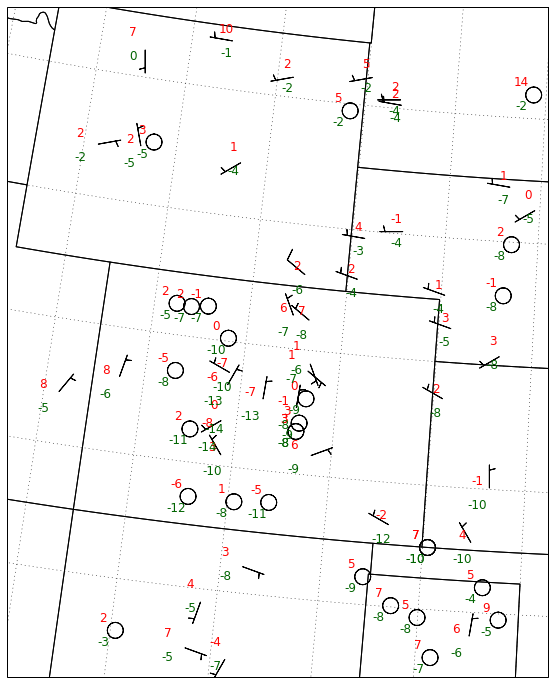

In [25]:
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover

ax = default_map(bb)

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also set the fontsize.
stationplot = StationPlot(ax, lons, lats, transform=cartopy.crs.PlateCarree(),
                          fontsize=12)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', tair, color='red')
stationplot.plot_parameter('SW', dewp, color='darkgreen')

# Add wind barbs
stationplot.plot_barb(u, v)

In addition to plotting values, `StationPlot` has support for plotting text strings, symbols, and plotting values using custom formatting.

Plotting symbols involves mapping integer values to various custom font glyphs in our custom weather symbols font. MetPy provides mappings for converting WMO codes to their appropriate symbol. The `sky_cover` function below is one such mapping.

Below we also use a custom formatter to take the sea level pressure values and plot them in the prototypical 3 digit form.

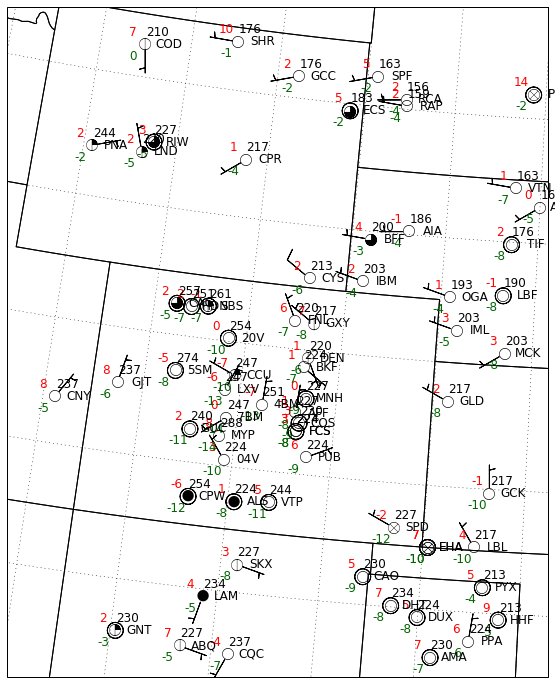

In [26]:
from metpy.plots.wx_symbols import sky_cover

ax = default_map(bb)

# Same as before
stationplot = StationPlot(ax, lons, lats, transform=cartopy.crs.PlateCarree(),
                          fontsize=12)
stationplot.plot_parameter('NW', tair, color='red')
stationplot.plot_parameter('SW', dewp, color='darkgreen')
stationplot.plot_barb(u, v)

# Plot the sky cover symbols in the center. We give it the integer code values that
# should be plotted, as well as a mapping class that can convert the integer values
# to the appropriate font glyph.
stationplot.plot_symbol('C', cloud_cover, sky_cover)

# Plot station id -- using an offset pair instead of a string location
stationplot.plot_text((2, 0), stid)

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', slp,
                           formatter=lambda v: format(10 * v.magnitude, '.0f')[-3:])

### Station plots using layouts

Station plots can also be created using layouts, which encapsulate the formatting elements for various data types (based on string name). Formatting elements include:
- Text format (e.g. color)
- Location (N, S, etc.)
- Custom string formatting
- Barbs
- units
- Symbol mapping (such as sky cover)

In [27]:
from metpy.plots import simple_layout
simple_layout.names()

['eastward_wind',
 'northward_wind',
 'air_pressure_at_sea_level',
 'cloud_coverage',
 'air_temperature',
 'present_weather',
 'dew_point_temperature']

Using the layout takes data arrays stored in a dictionary like object, where the keys represent data fields. (In an ideal world, you could just pass a netCDF4 `Dataset` instance with CF-compliant names...)

The layout will ignore any fields that aren't present. When given data, it will ignore any names (keys) that are not specified in the layout. It is designed to be as forgiving as possible.

In [28]:
sfc_data = {'air_temperature': tair, 'dew_point_temperature': dewp, 'eastward_wind': u,
            'northward_wind': v, 'cloud_coverage': cloud_cover,
            'air_pressure_at_sea_level': slp}

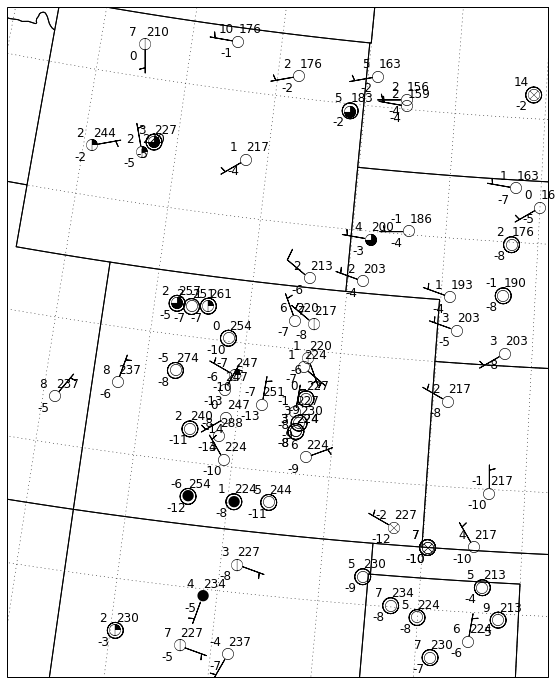

In [29]:
ax = default_map(bb)
stationplot = StationPlot(ax, lons, lats, fontsize=12,
                          transform=cartopy.crs.PlateCarree())
simple_layout.plot(stationplot, sfc_data)

You can also create your own layout:

In [30]:
from metpy.plots import StationPlotLayout
layout = StationPlotLayout()

layout.add_barb('u', 'v', 'knots')
layout.add_symbol('C', 'sky', sky_cover)

# These are wider fields, so we'll put them out wider
layout.add_text((2, 0), 'station', color='blue')
layout.add_value((-2, 0), 'temp', fmt='0.1f', units='degF', color='red')

So we'll put data into a dictionary to display...

In [31]:
sfc_data = {'temp': tair * units('degC'), 'sky':cloud_cover, 'u': u, 'v': v,
            'station': stid}

and create the plot.

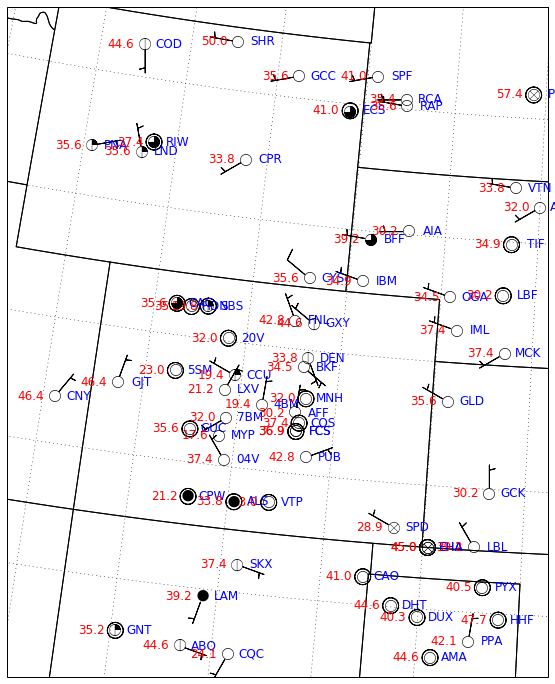

In [32]:
ax = default_map(bb)
stationplot = StationPlot(ax, lons, lats, fontsize=12,
                          transform=cartopy.crs.PlateCarree())
layout.plot(stationplot, sfc_data)

MetPy has many more symbols for current weather and cloud types; we just lack the data to readily show them off at present. Exhaustive list:
- current_weather
- current_weather_auto (automated station)
- low_clouds
- mid_clouds
- high_clouds
- sky_cover
- pressure_tendency

These all assume WMO code values for these items, and they all can be passed as a mapper for a symbol field in the station plot code (either `plot_symbol` for `StationPlot` or `add_symbol` for `StationPlotLayout`)

Below we show code to display all of the weather symbols:

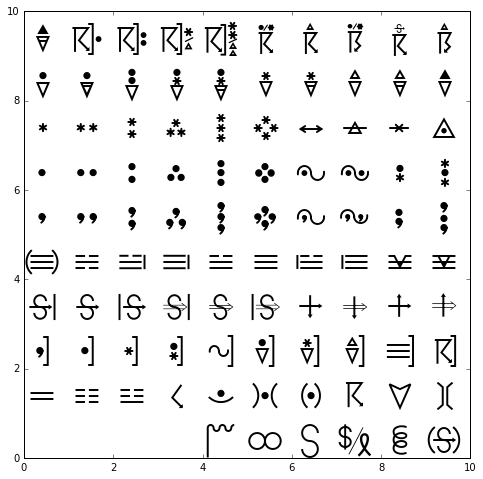

In [33]:
# Get the mapper that converts a code for current weather (from WMO) to the appropriate
# unicode code point
from metpy.plots.wx_symbols import current_weather, wx_symbol_font

# Need to make a new copy of the font so we can make it bigger
big_font = wx_symbol_font.copy()
big_font.set_size(36)

# Create a plot to loop over all of the codes and display it
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for i in range(100):
    ax.text(i % 10, i // 10, current_weather(i), fontproperties=big_font)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10);

Or sky cover symbols:

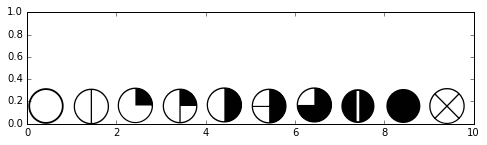

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
for i in range(10):
    ax.text(i, 0, sky_cover(i), fontproperties=big_font)
ax.set_xlim(0, 10)
ax.set_ylim(0, 1);

### Exercise: Make your own station plot
Time to play around with the station plot. Take some of the data we grabbed (or change the query and download data for a different area) and pass it to the station plotting routines. You can use either the direct `StationPlot` class or create your own layout. If you want to play with the various symbols, you can randomly generate integer codes using `numpy.random.randint(low, high)`